In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import math
from scipy import stats
import acquire as a
import prepare as p

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

### Stakeholder:

VP of Product: Which product line should we expand?

- Is there a product category that is particularly profitable for us?
- Does one or another stand out in terms of sales volume?
- Does this vary by customer segment?

In [2]:
df = a.get_superstore_data()

In [3]:
df = p.prepare_superstore(df)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1734 entries, 2014-01-04 to 2017-12-30
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Customer ID    1734 non-null   object        
 1   Order ID       1734 non-null   object        
 2   Ship Date      1734 non-null   datetime64[ns]
 3   Ship Mode      1734 non-null   object        
 4   Segment        1734 non-null   object        
 5   Country        1734 non-null   object        
 6   City           1734 non-null   object        
 7   State          1734 non-null   object        
 8   Postal Code    1734 non-null   float64       
 9   Sales          1734 non-null   float64       
 10  Quantity       1734 non-null   float64       
 11  Discount       1734 non-null   float64       
 12  Profit         1734 non-null   float64       
 13  Category       1734 non-null   object        
 14  Sub-Category   1734 non-null   object        
 15  Cus

In [5]:
df.describe() .T

,count,mean,std,min,25%,50%,75%,max
Postal Code,1734.0,53501.926182,32180.245224,1841.0000,19143.0000,50315.00000,85705.00000,98661.000
Sales,1734.0,229.206358,532.862614,1.0800,16.6950,52.24500,209.91750,8159.952
Quantity,1734.0,3.794694,2.297407,1.0000,2.0000,3.00000,5.00000,14.000
Discount,1734.0,0.160110,0.206419,0.0000,0.0000,0.20000,0.20000,0.800
Profit,1734.0,21.880351,202.891949,-3839.9904,1.7024,8.07305,27.41445,3177.475
Sales Total,1734.0,1197.630083,3635.417038,1.2480,46.4560,172.47600,774.37900,65279.216
Profitable,1734.0,0.803922,0.397143,0.0000,1.0000,1.00000,1.00000,1.000


In [6]:
df.isna().sum()

Customer ID      0
Order ID         0
Ship Date        0
Ship Mode        0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Sales            0
Quantity         0
Discount         0
Profit           0
Category         0
Sub-Category     0
Customer Name    0
Product Name     0
Region Name      0
Sales Total      0
Profitable       0
dtype: int64

In [7]:
df.nunique()

Customer ID       525
Order ID          841
Ship Date         608
Ship Mode           4
Segment             3
Country             1
City              247
State              41
Postal Code       306
Sales            1504
Quantity           14
Discount           12
Profit           1589
Category            3
Sub-Category       17
Customer Name     525
Product Name     1091
Region Name         4
Sales Total      1536
Profitable          2
dtype: int64

### Date Range: 2014-01-04 to 2017-12-30

In [8]:
train_slice = round(len(df) * 0.7)
val_slice = round(len(df) * 0.85)

In [9]:
train = df[:train_slice]
val = df[train_slice:val_slice]
test = df[val_slice:]

In [10]:
len(df) == len(train) + len(val) + len(test)

True

In [11]:
profit_df = train.Profit.resample('D').sum()

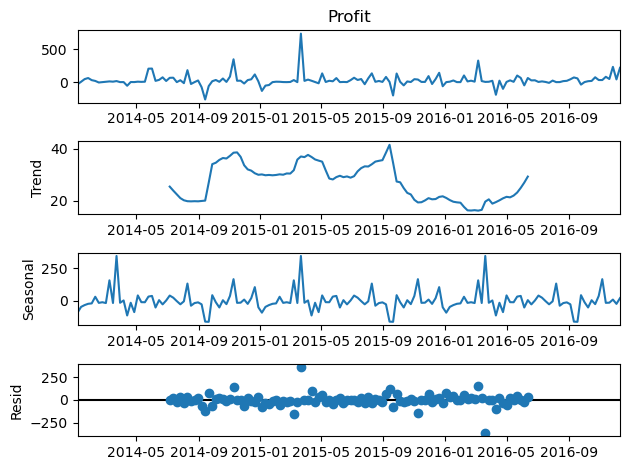

In [12]:
sm.tsa.seasonal_decompose(profit_df.resample('W').mean()).plot()
None

Note:
- Looks synthetic
- Profit spike in march

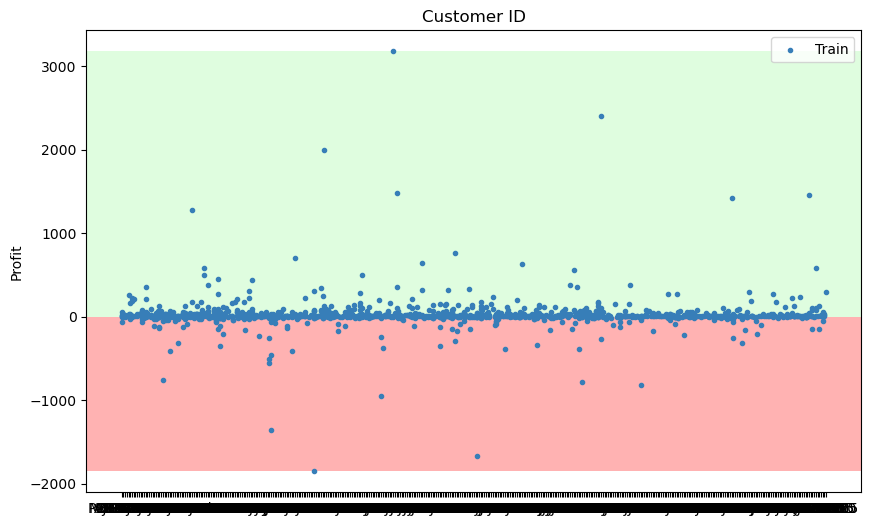

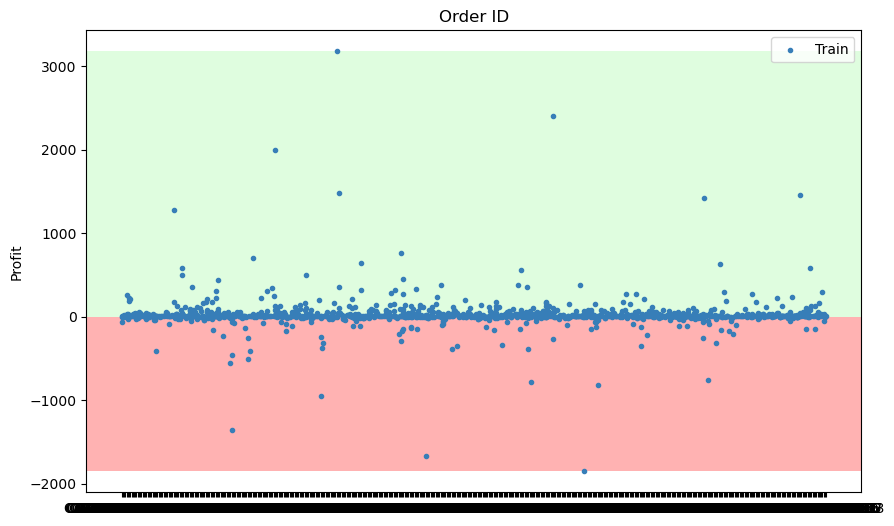

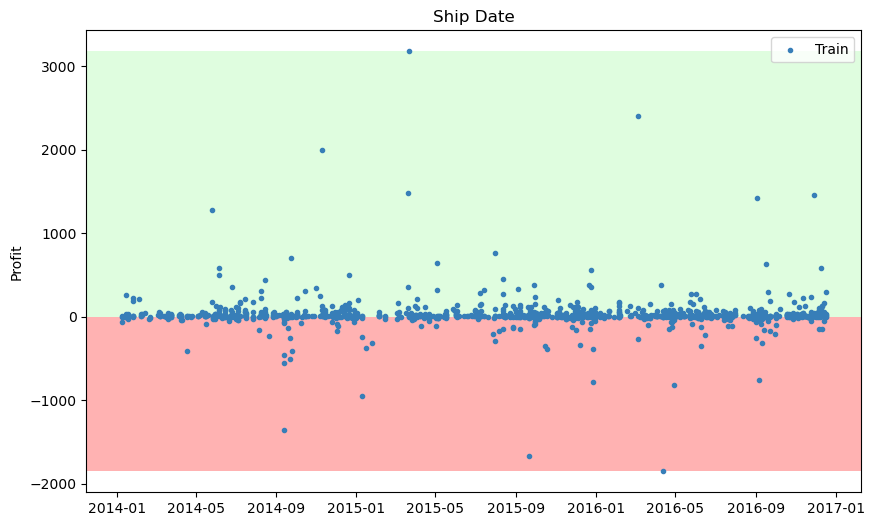

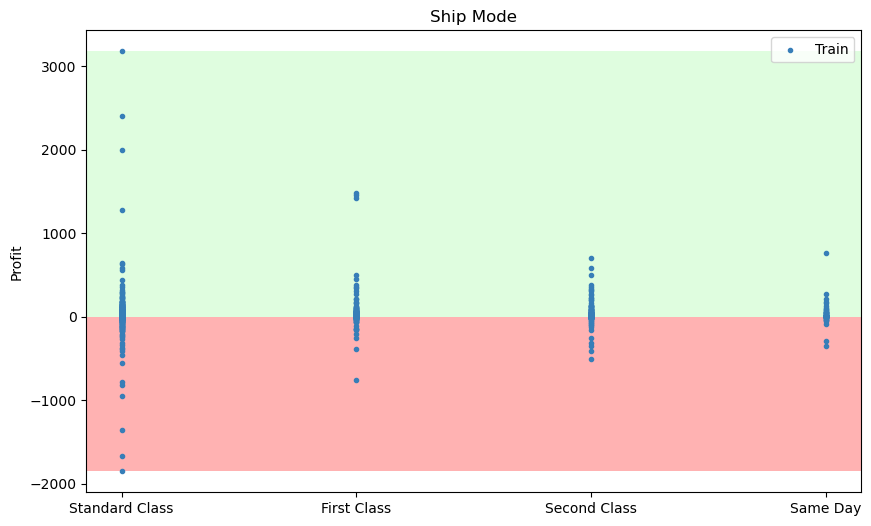

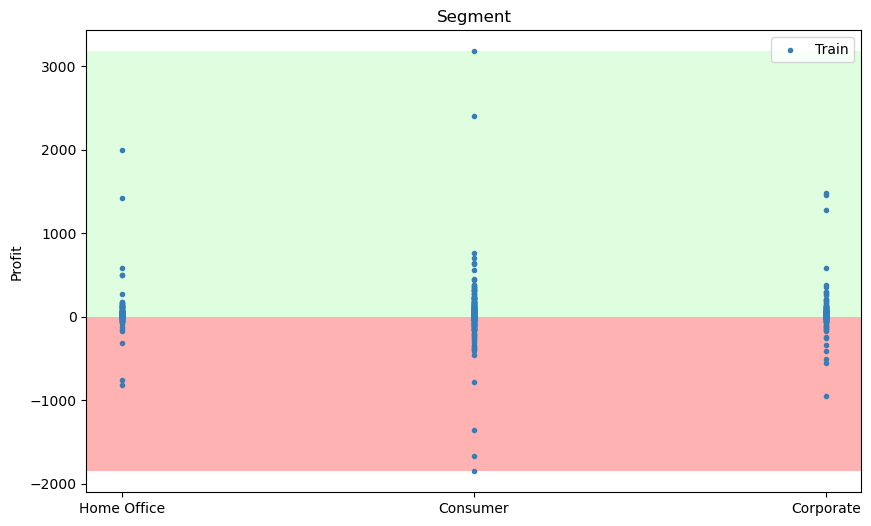

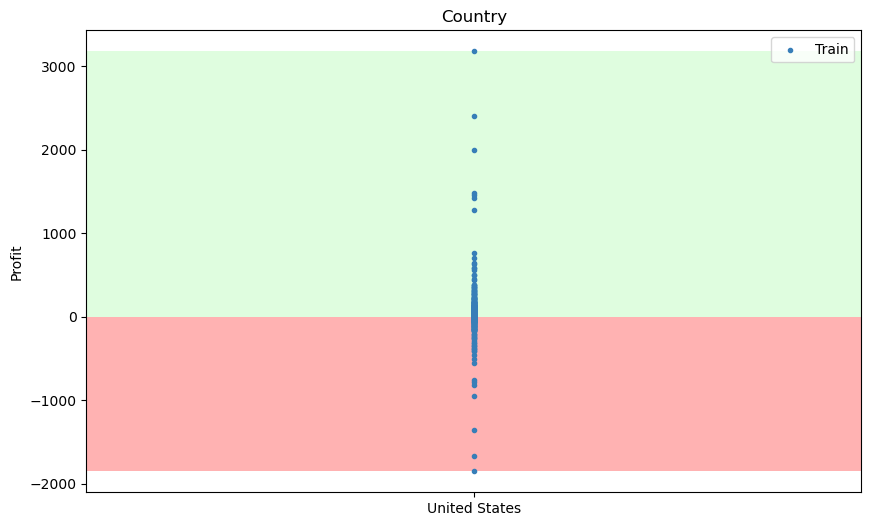

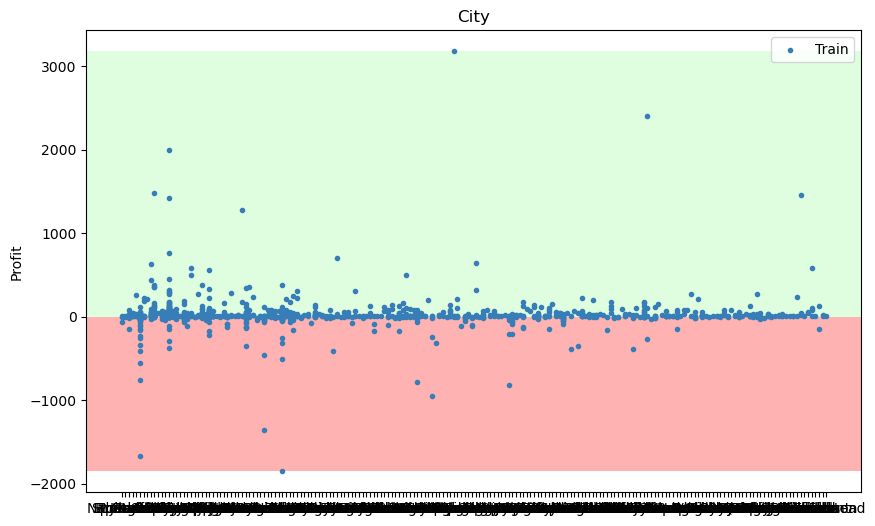

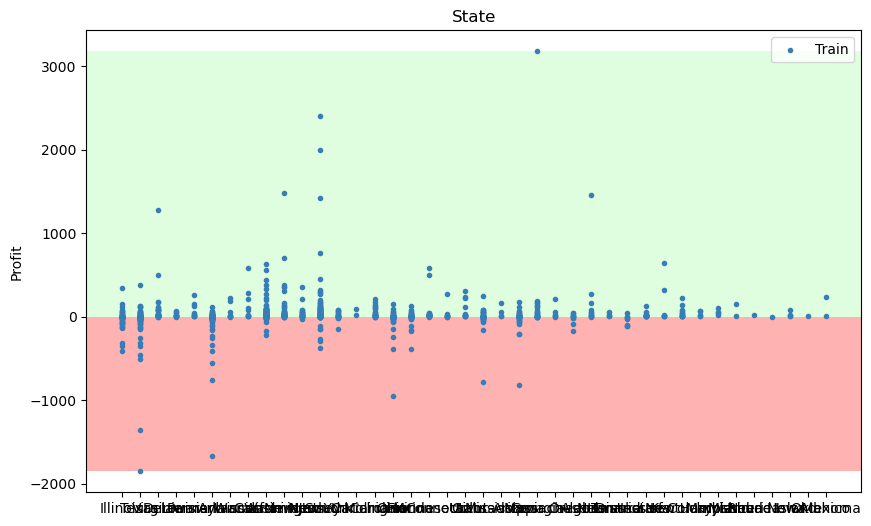

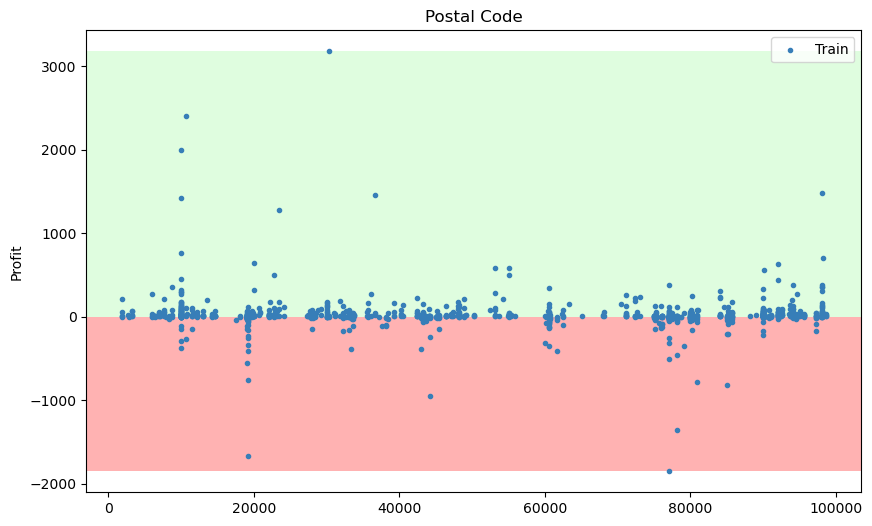

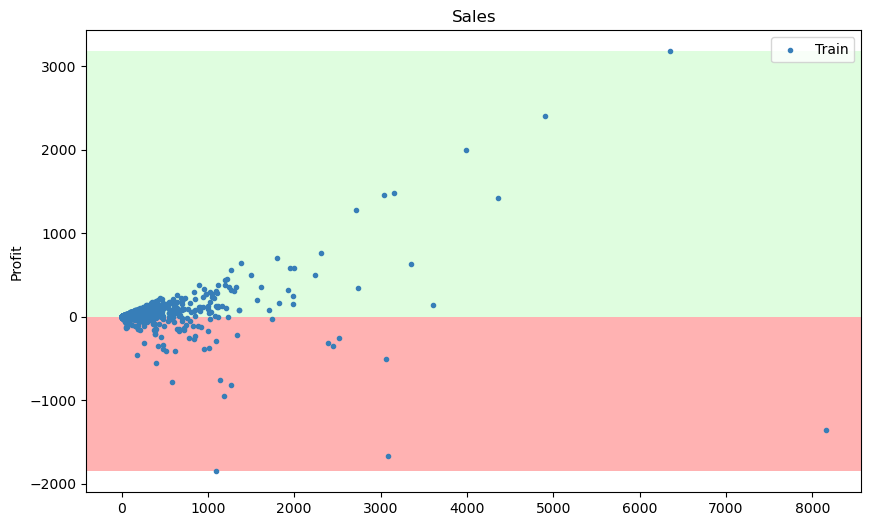

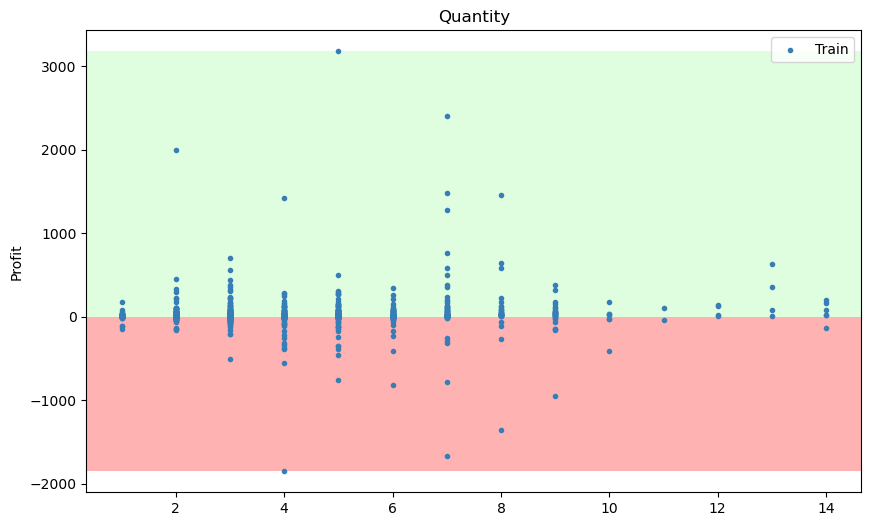

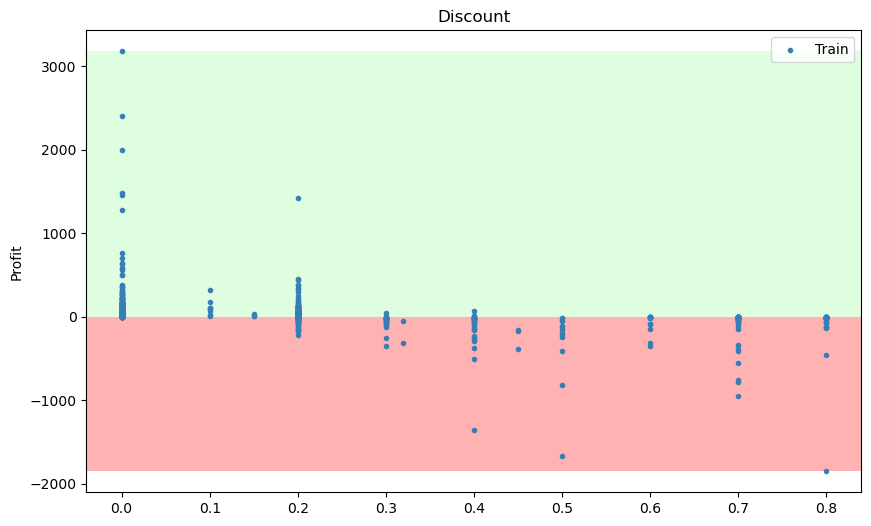

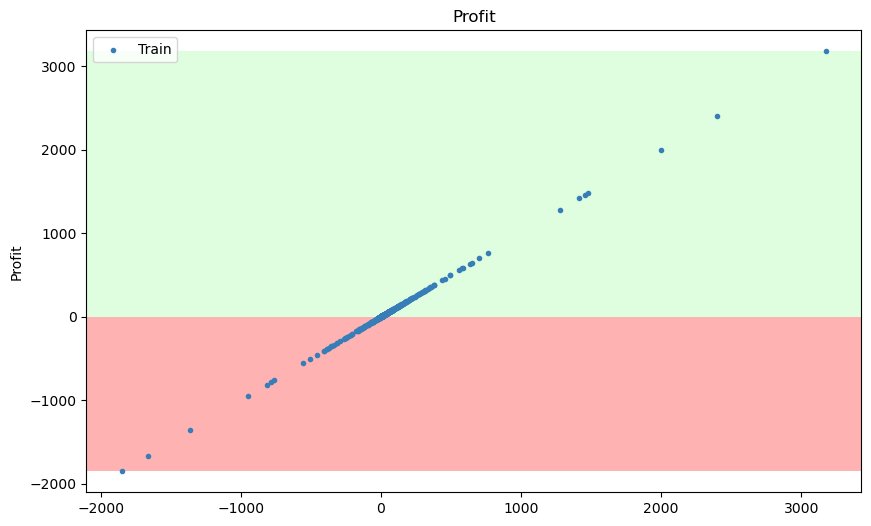

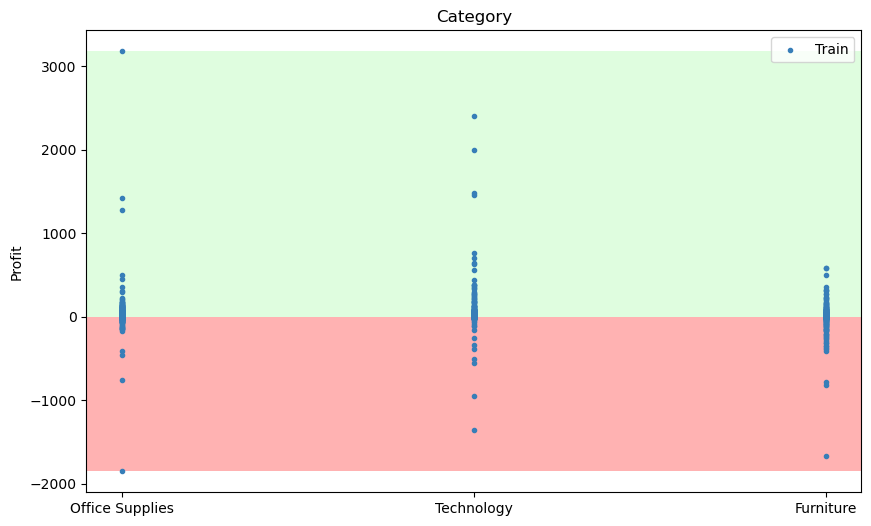

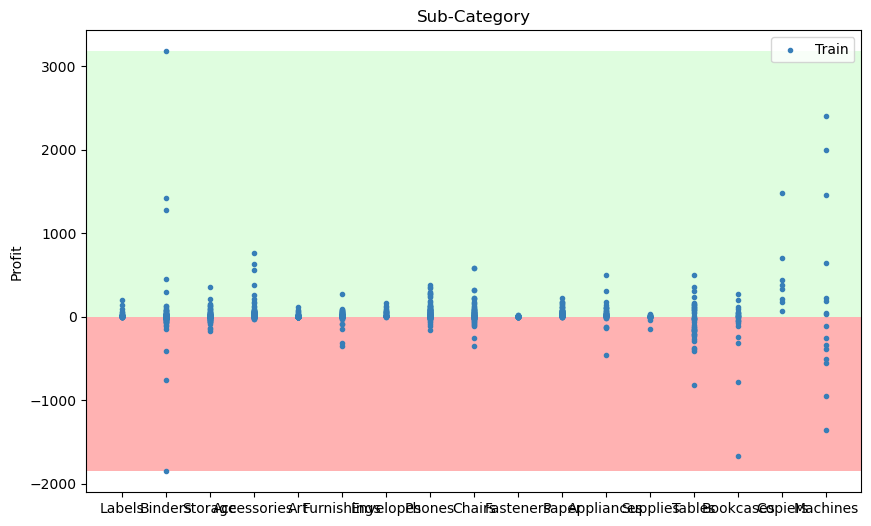

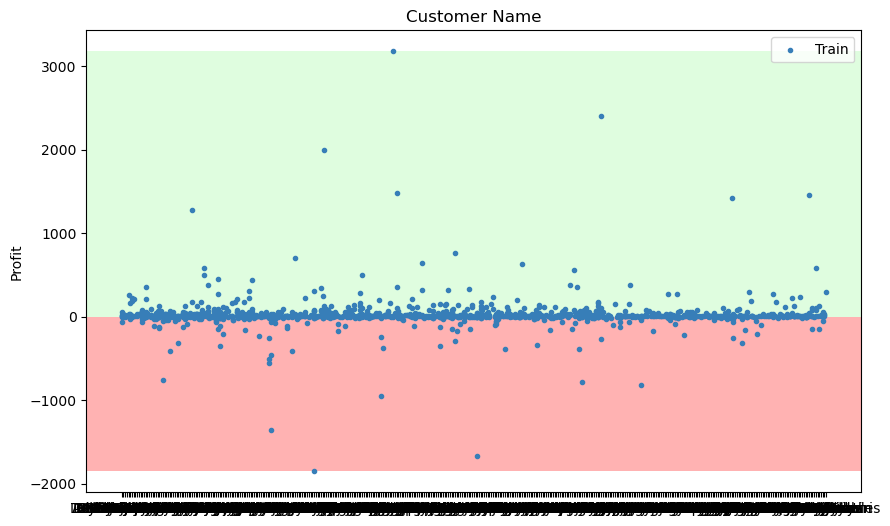

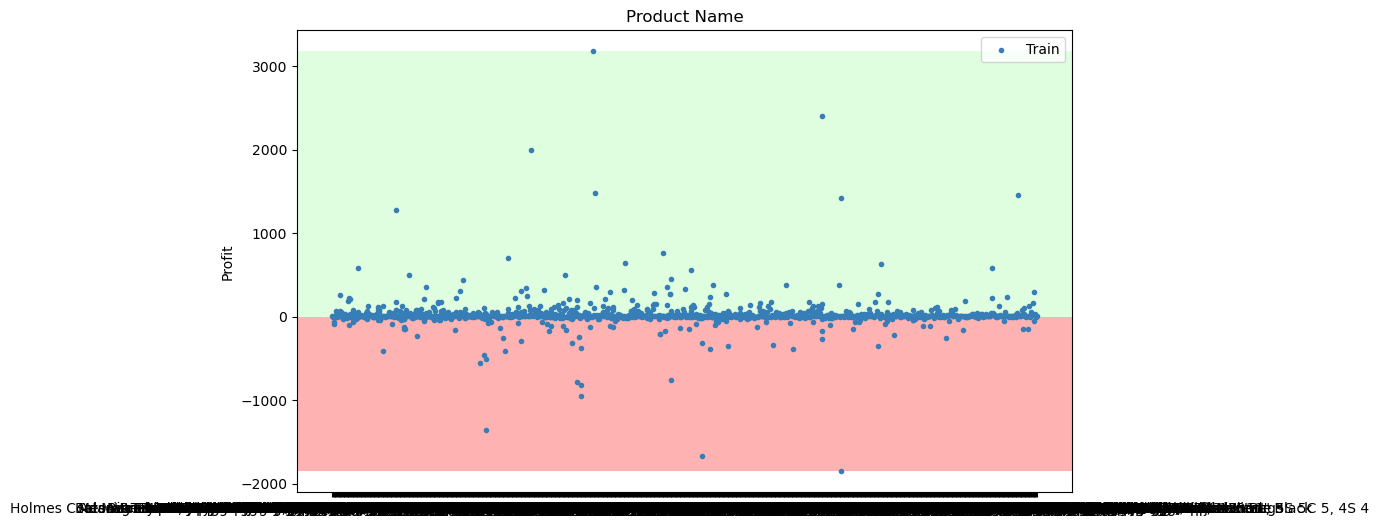

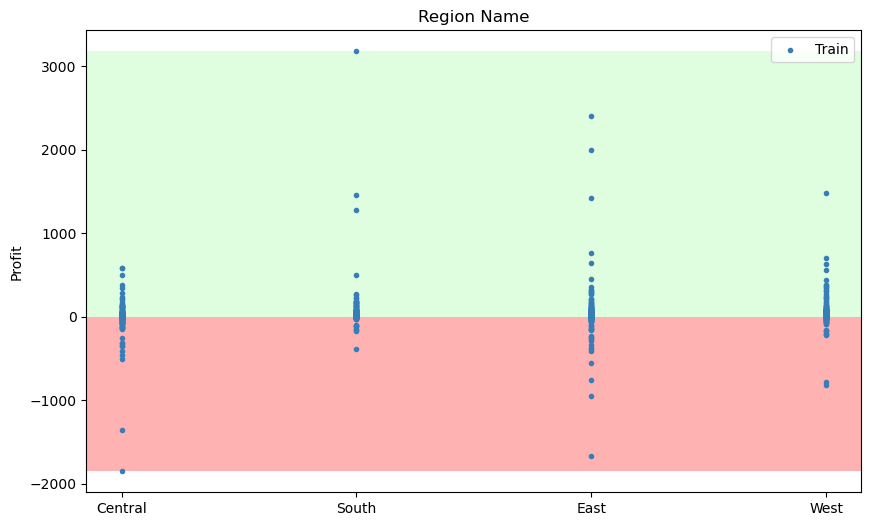

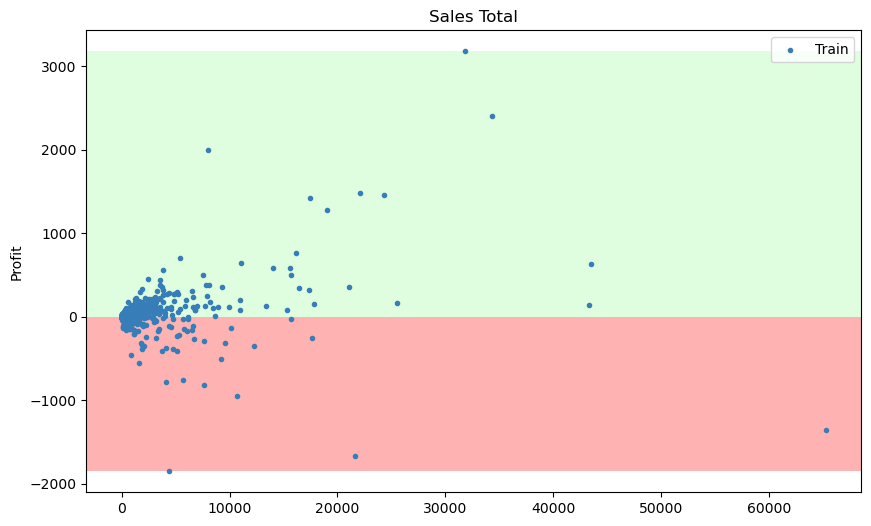

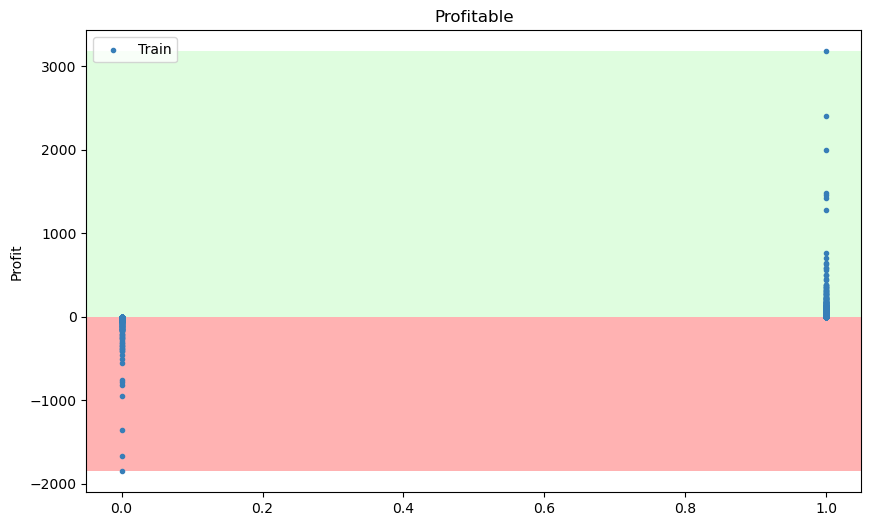

In [13]:
for col in train.columns:
    plt.figure(figsize=(10,6))
    plt.axhspan(0, train['Profit'].min(), facecolor='red', alpha=0.3)
    plt.axhspan(0, train['Profit'].max(), facecolor='palegreen', alpha=0.3)
    plt.scatter(train[col], train['Profit'], color='#377eb8', label = 'Train', marker = '.')
    plt.legend()
    plt.ylabel('Profit')
    plt.title(col)
    plt.show()

In [14]:
train.columns

Index(['Customer ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Segment',
       'Country', 'City', 'State', 'Postal Code', 'Sales', 'Quantity',
       'Discount', 'Profit', 'Category', 'Sub-Category', 'Customer Name',
       'Product Name', 'Region Name', 'Sales Total', 'Profitable'],
      dtype='object')

In [15]:
target_column = 'Profitable'
target_col = 'Profit'

In [16]:
def t_test_cats(train, target_column, alpha = 0.05):
    """
    Input DataFrame and a string of the target_column name.
    Performs chi^2 test with a default alpha of 0.05 on each categorical feature.
    Prints a visualization and list of columns whos data occures exclusivly 
    in the target group or non-target group.
    """

    #Lists to hold variables
    distros = []
    drivers = []
    non_drivers = []
    t_test_result = []
    
    #This snags int columns and drops those that have more than 2 values.
    plot_df = train.select_dtypes(exclude=['object', 'bool', 'datetime'])
    
    #Seperating target rows
    target_df = plot_df[plot_df[target_column] == 1]

    #Warning that the below is prefered... IDK why:
    #df.loc[:,('one','second')]
    target_df.drop(columns=target_column, inplace = True)
    
    #Seperating non-target rows
    not_target = plot_df[plot_df[target_column] == 0]
    not_target.drop(columns=target_column, inplace = True)
    
    #Creating the Target Indication DataFrame

    for item in target_df:
        target = round(target_df[item].mean(),3)
        not_tar = round(not_target[item].mean(),3)
        if item == 'UDI':
            pass
        else:
            output = {"Column" : item,
                      "Target %": target, 
                      "Not Target %": not_tar,
                      "Target Indication":(target - not_tar)}

            distros.append(output)

    #This turns the info into a DataFrame
    distro_df = pd.DataFrame(distros)              
    distro_df = distro_df.set_index('Column')

    #Seperate out columns to investigate, Target Indication = 1 or -1

    for feature in distro_df.T:

    # Let's run a chi squared to compare proportions, to have more confidence
        null_hypothesis = f'{feature} and {target_column} have no difference in means.'
        alternative_hypothesis = f'there is a difference in means between {feature} and {target_column}'

        #Stats test
        t_stat, p_value = stats.ttest_ind(target_df[feature], not_target[feature])

        #Answer logic
        if p_value < alpha:
            t_test_result.append('Different Means')

        else:
            t_test_result.append('Similar Means')
        
    distro_df['t_test_result'] = t_test_result

    
    #Plotting the relationship with the target variable (and stats test result)
    my_range=range(1,len(distro_df.index) + 1)
    hue_colors = {'Different Means': 'green', 'Similar Means':'red'}
    style_order = {'Different Means': 'o', 'Similar Means':'x'}

    plt.figure(figsize=(6,4))
    plt.axvline(0, c='tomato', alpha=.6)

    plt.hlines(y=my_range, xmin=-2500, xmax=500, color='grey', alpha=0.4)
    sns.scatterplot(data=distro_df, x='Target Indication',
                    y=my_range, hue='t_test_result', palette=hue_colors,
                    style='t_test_result', style_order=style_order)
    plt.legend(title='T-test result')

    # Add title and axis names
    plt.yticks(my_range, distro_df.index)
    plt.title(f'Comparison of profitable versus not profitable', loc='center')
    plt.xlabel('T-Statistic')
    plt.ylabel('Feature')
    

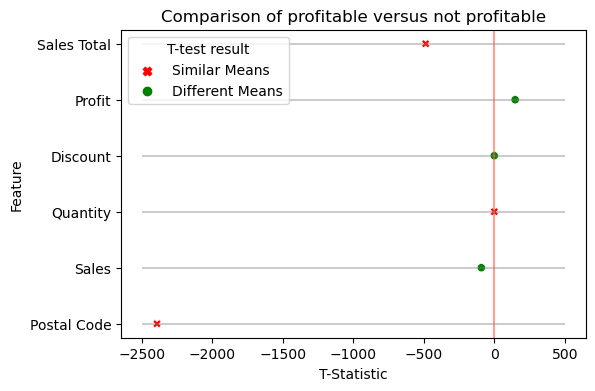

In [17]:
t_test_cats(train, target_column)

In [18]:
def correlation_test(df, target_col, alpha=0.05):
    """
    Maybe create a function that automatically seperates continuous from discrete columns.
    """
    
    list_of_cols = df.select_dtypes(include=[int, float]).columns
              
    metrics = []
    for col in list_of_cols:
        result = stats.anderson(df[col])
        #Checks skew to pick a test
        if (result.statistic < result.critical_values[0]) and (len(df[col]) > 100):
            corr, p_value = stats.pearsonr(df[target_col], df[col])
            test_type = '(P)'
        else:
            # I'm unsure how this handles columns with null values in it.
            corr, p_value = stats.spearmanr(df[target_col],
                                            df[col], nan_policy='omit')
            test_type = '(S)'

        #Answer logic
        if p_value < alpha:
            test_result = 'relationship'
        else:
            test_result = 'independent'
        if col == target_col:
            pass
        else:
            temp_metrics = {"Column":f'{col} {test_type}',
                        "Correlation": corr,
                        "P Value": p_value,
                        "Test Result": test_result}
            metrics.append(temp_metrics)
    distro_df = pd.DataFrame(metrics)              
    distro_df = distro_df.set_index('Column')

    #Plotting the relationship with the target variable (and stats test result)
    my_range=range(1,len(distro_df.index) + 1)
    hue_colors = {'relationship': 'green', 'independent':'red'}

    plt.figure(figsize=(5,4))
    plt.axvline(0, c='tomato', alpha=.6)

    plt.hlines(y=my_range, xmin=-1, xmax=1, color='grey', alpha=0.4)
    sns.scatterplot(data=distro_df, x="Correlation",
                    y=my_range, hue="Test Result", palette=hue_colors,
                    style="Test Result", style_order= hue_colors)
    plt.legend(title="Stats test result")

    # Add title and axis names
    plt.yticks(my_range, distro_df.index)
    plt.title(f'Statistics tests of {target_col}', loc='center')
    plt.xlabel('Neg Correlation            No Correlation            Pos Correlation')
    plt.ylabel('Feature')
    
    #Saves plot when it has a name and uncommented
    #plt.savefig(f'{train.name}.png')


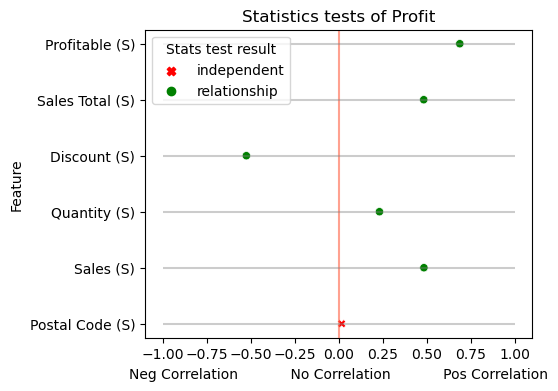

In [19]:
correlation_test(df, target_col)

In [20]:
train.Profit.quantile(q=.75)

28.81244999999999

In [22]:
train[train.Profit > 28.0]['Product Name'].value_counts()

netTALK DUO VoIP Telephone Service                              3
Imation Secure+ Hardware Encrypted USB 2.0 Flash Drive; 16GB    3
Easy-staple paper                                               3
Logitech G19 Programmable Gaming Keyboard                       3
KI Adjustable-Height Table                                      3
                                                               ..
Brother DCP1000 Digital 3 in 1 Multifunction Machine            1
Hoover Shoulder Vac Commercial Portable Vacuum                  1
Maxell 4.7GB DVD-R                                              1
Avery 485                                                       1
First Data FD10 PIN Pad                                         1
Name: Product Name, Length: 256, dtype: int64